# <span style='color:#ff5f27'> Initialization </span>

### Hopsworks Settings

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/federica_lorenzini/sml-bike-sharing
HopsworksSettings initialized!


### Imports

In [2]:
from datetime import date, datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs import util
import json

import warnings
warnings.filterwarnings("ignore")

# <span style='color:#ff5f27'> Retrieve Data </span>

### Retrieve Metadata

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("BIKES_LOCATION_JSON").value
location = json.loads(location_str)

country=location['country']
city=location['city']
latitude=location['latitude']
longitude=location['longitude']
today = date.today()
yesterday = today - timedelta(days=1)

print(f"City: {city}")
print(f"Contry: {country}")
print(f"Latitude: {latitude}")
print(f"Longitude: {longitude}")
print(f"Day: {today}")

2026-01-11 15:53:14,667 INFO: Initializing external client
2026-01-11 15:53:14,670 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-11 15:53:16,865 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279175
City: Trento
Contry: Italy
Latitude: 46.07
Longitude: 11.12
Day: 2026-01-11


### Connect to Feature Groups

In [4]:
bikes_fg = fs.get_feature_group(
    name='bikes_trento',
    version=2,
)
weather_fg = fs.get_feature_group(
    name='weather_trento',
    version=2,
)

### Create Feature Views

In [5]:
selected_features = bikes_fg.select(
    ['name', 'bikes', 'date']
).join(weather_fg.select_features(), on=['city'])

2026-01-11 15:53:19,381 INFO: Using ['weather_code', 'apparent_temperature_mean', 'daylight_duration', 'precipitation_sum', 'wind_speed_10m_max'] from feature group `weather_trento` as features for the query. To include primary key and event time use `select_all`.


In [6]:
feature_view = fs.get_or_create_feature_view(
    name='bikes_fv',
    description="Features Selected for Bike Predictions",
    version=2,
    labels=['bikes'],
    query=selected_features,
)

In [7]:
feature_view = fs.get_feature_view(name="bikes_fv", version=2)
feature_view.schema

[Training Dataset Feature('name', 'string', 0, False, name, 1893939, None),
 Training Dataset Feature('bikes', 'int', 1, True, bikes, 1893939, None),
 Training Dataset Feature('date', 'timestamp', 2, False, date, 1893939, None),
 Training Dataset Feature('weather_code', 'int', 3, False, weather_code, 1893940, None),
 Training Dataset Feature('apparent_temperature_mean', 'float', 4, False, apparent_temperature_mean, 1893940, None),
 Training Dataset Feature('daylight_duration', 'float', 5, False, daylight_duration, 1893940, None),
 Training Dataset Feature('precipitation_sum', 'float', 6, False, precipitation_sum, 1893940, None),
 Training Dataset Feature('wind_speed_10m_max', 'float', 7, False, wind_speed_10m_max, 1893940, None)]

# <span style='color:#ff5f27'> Create Train/Test Datasets </span>

### Retrieve the Data

In [8]:
start_date_test_data = "2025-06-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
# The line that generates the error:

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.54s) 


In [10]:
X_train.head()

,name,date,weather_code,apparent_temperature_mean,daylight_duration,precipitation_sum,wind_speed_10m_max
0,11.02 Stazione TN-Male`,2024-11-01 15:13:45+00:00,2,14.199712,36237.121094,0.0,4.846648
1,22.01 Pomarolo,2024-11-01 15:13:45+00:00,2,14.199712,36237.121094,0.0,4.846648
2,10.09 Centro Santa Chiara,2024-11-01 15:13:45+00:00,2,14.199712,36237.121094,0.0,4.846648
3,10.35 Studentato San Bartolomeo,2024-11-01 15:13:45+00:00,2,14.199712,36237.121094,0.0,4.846648
4,10.07 Biblioteca,2024-11-01 15:13:45+00:00,2,14.199712,36237.121094,0.0,4.846648


### Remove Date and Parse Categories

In [11]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

X_features['name'] = X_features['name'].astype("category")
X_features['weather_code'] = X_features['weather_code'].astype("category")
X_test_features['name'] = X_test_features['name'].astype("category")
X_test_features['weather_code'] = X_test_features['weather_code'].astype("category")

### Print Info

In [12]:
X_features.head()

,name,weather_code,apparent_temperature_mean,daylight_duration,precipitation_sum,wind_speed_10m_max
0,11.02 Stazione TN-Male`,2,14.199712,36237.121094,0.0,4.846648
1,22.01 Pomarolo,2,14.199712,36237.121094,0.0,4.846648
2,10.09 Centro Santa Chiara,2,14.199712,36237.121094,0.0,4.846648
3,10.35 Studentato San Bartolomeo,2,14.199712,36237.121094,0.0,4.846648
4,10.07 Biblioteca,2,14.199712,36237.121094,0.0,4.846648


In [13]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96941 entries, 0 to 96940
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   name                       96941 non-null  category
 1   weather_code               96941 non-null  category
 2   apparent_temperature_mean  96941 non-null  float32 
 3   daylight_duration          96941 non-null  float32 
 4   precipitation_sum          96941 non-null  float32 
 5   wind_speed_10m_max         96941 non-null  float32 
dtypes: category(2), float32(4)
memory usage: 2.4 MB


In [14]:
y_train.head()

,bikes
0,1
1,0
2,3
3,3
4,9


In [15]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96941 entries, 0 to 96940
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   bikes   96941 non-null  int32
dtypes: int32(1)
memory usage: 1.1 MB


# <span style='color:#ff5f27'> Train the Model </span>

### Instantiate and Train an XGBoost Model

In [16]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(enable_categorical=True)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Compute the Evaluation Metrics

In [17]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 18.402569589227657
R squared: 0.10509477718940352


### Create Comparison Dataframe

In [18]:
df = y_test
df['predicted_bikes'] = y_pred
df['date'] = X_test['date']
df['name'] = X_test['name']
df = df.sort_values(by=['date'])
df.head(10)

,bikes,predicted_bikes,date,name
96941,5,6.345627,2025-06-01 00:03:19+00:00,10.04 Piazza Venezia
96942,3,1.904960,2025-06-01 00:12:20+00:00,10.23 Mattarello
96943,4,3.015646,2025-06-01 00:21:18+00:00,10.34 Madonna Bianca
96944,7,0.609655,2025-06-01 00:21:18+00:00,26.01 Mori
96945,3,1.904960,2025-06-01 00:27:20+00:00,10.23 Mattarello
96946,4,3.015646,2025-06-01 00:33:18+00:00,10.34 Madonna Bianca
96947,4,1.187345,2025-06-01 00:33:18+00:00,20.24 Ex Marangoni
96948,3,1.726593,2025-06-01 00:39:19+00:00,10.18 Vannetti
96949,8,5.957283,2025-06-01 00:57:20+00:00,10.12 Azienda Sanitaria
96950,2,1.214017,2025-06-01 01:00:21+00:00,20.09 Sacco


### Create a directory for the model artifacts

In [19]:
model_dir = "trento_bikes_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
#images_dir = model_dir + "/images"
images_dir = "trento_bikes_hindcast"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

### Plot the Hindcast

In [20]:
metadata = pd.DataFrame()
metadata['name'] = df['name'].drop_duplicates()  
metadata.head()

,name
96941,10.04 Piazza Venezia
96942,10.23 Mattarello
96943,10.34 Madonna Bianca
96944,26.01 Mori
96947,20.24 Ex Marangoni


In [21]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 96941 to 97191
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    85 non-null     object
dtypes: object(1)
memory usage: 1.3+ KB


In [22]:
for i in range(metadata.shape[0]):
    name = metadata.iloc[i]['name']
    file_path = images_dir + "/bikes_hindcast_" + name + ".png"
    df_i = df[df['name'] == name]

    # plot_bikes_forecast wants microsecond, but df_i don't have them, so we set them to 0
    df_i['date'] = df_i['date'].apply(lambda x: pd.Timestamp(x).replace(microsecond=0))

    plt = util.plot_bikes_forecast(city, name, df_i, file_path, hindcast=True)
    plt.close()

### Plotting Feature Importances

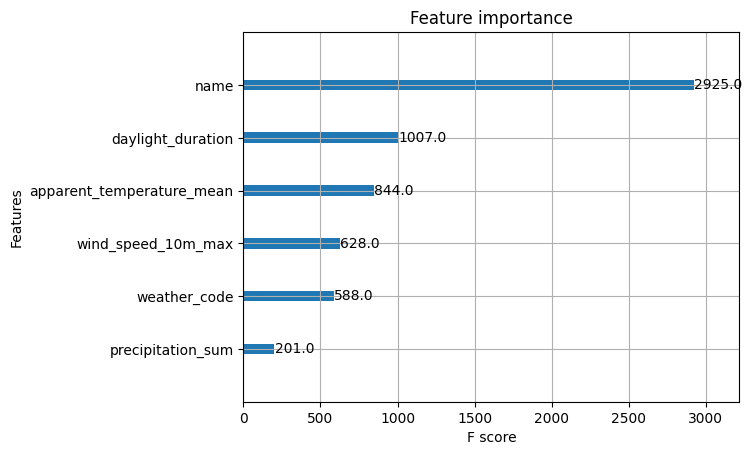

In [23]:
plot_importance(xgb_regressor)
feature_importance_path = model_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

# <span style='color:#ff5f27'> Save the Model </span>

### Save the Model Locally

In [24]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/trento_bikes_xgboost_model.json")

### Get Model Registry

In [25]:
mr = project.get_model_registry()

### Push the Model to Hopsworks

In [26]:
res_dict = { 
    "MSE": str(mse),
    "R squared": str(r2),
}

In [27]:
bikes_model = mr.python.create_model(
    name="trento_bikes_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Bikes Predictor for Trento",
)

In [28]:
bikes_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/federica_lorenzini/sml-bike-sharing/trento_bikes_model/feature_importance.png: 0.000%|        …

Uploading /home/federica_lorenzini/sml-bike-sharing/trento_bikes_model/trento_bikes_xgboost_model.json: 0.000%…

Uploading /home/federica_lorenzini/sml-bike-sharing/model_schema.json: 0.000%|          | 0/704 elapsed<00:00 …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279175/models/trento_bikes_xgboost_model/4


Model(name: 'trento_bikes_xgboost_model', version: 4)